# **Report**

Our main goal in this report is to become aware of the main principals of Artificial Neural Networks and their comparison against Convolutional Neural Networks. 

## Importing the necessary packages

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
%matplotlib inline

## Data Manipulation

### Loading the Images and Partioning the Data

We load the necessary images and partioning our data into training and test datasets

In [2]:
# Enter the path of our image files
path = r'C:\Users\ilker\Desktop\BBM409_Homework_Workspace\Assignment4_Workspace\animals\raw-img'
all_folders = os.listdir(path) # Take all the folders within directory

file_paths = [] # Paths of all files
classes = [] # Respective classes of all files

for i, folder in enumerate(all_folders): # Within each folder (which corresponds to each class)
    
    all_file_paths = os.listdir(path + "\\" + folder); # Enter the folder and store every path of every file within
    
    for file in all_file_paths: # For each file in the folder
        
        classes.append(i) # Add its class to the class list
        file_paths.append(path+ "\\" + folder + "\\" + file) # Add its path to the file paths list
        

# Create a dataframe to hold our datasets
df = pd.DataFrame({
    'filename': file_paths,
    'class': classes
})

# Update our classes into integers for future ease of use
df["class"] = df["class"].astype(int)

# Create two dataframes to act as both training and test datasets
train_df = pd.DataFrame(columns=['filename', 'class'])
test_df = pd.DataFrame(columns=['filename', 'class'])


for i in range(10): # For each class possible
    train_df = train_df.append(df[df["class"] == i].iloc[:100,:]) # Take the first 100 images of a particular class for training
    test_df = test_df.append(df[df["class"] == i].iloc[100:,:]) # Take the rest as testing dataset

# Note, as we will work towards comparisons of different hyper-parameter and architectural differences of neural networks
# instead of making the training corporate production ready, we will mostly train with a relatively small set of training sets
# as it will speed us up greatly.

# Reset their indices
test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

### Preprocessing the Image Files

Here, we process every image in our datasets to work within our classifier model. In order to do this, we first turn the images into gray images as it will significantly reduce the complexity within our model while also fastening the running speed. We also resize all the images into a uniform size since for our Neural Network to work properly, we need an exact amount of pixels ie. input nodes. Then, we add the resultant images into our image lists, both for training and testing images. Later, we flatten the pixel matrix of our images into a single dimensional numpy array as we wish to input this matrix into our model later on and only single dimensional matrices are accepted. And lastly, we divide the values stored within the matrix with 255.0, so that we may have a normalized value between 0 and 1, which works a lot better within Artificial Neural Networks.

In [3]:
# Training image preprocessing
images = []

# Create a progress bar to ease the checking of performance and state of our program
with tqdm(total=len(train_df)) as progress_bar: 
    
    # For every file within our training dataset
    for path in train_df.filename.values: 
        # Read the current image
        img = cv2.imread(path)
        
        # Transform the image from BGR (since we us opencv, the default image's mode is BGR) to Gray image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize the image into a uniform state
        img = cv2.resize(img, (64,64))
        
        # Append the image into our list
        images.append(img)
        
        # Update the progress bar
        progress_bar.update(1)

#*************************************************
# Testing image preprocessing
test_images = []

# Create a progress bar to ease the checking of performance and state of our program
with tqdm(total=len(test_df)) as progress_bar:

    # For every file within our training dataset
    for path in test_df.filename.values:
        # Read the current image
        img = cv2.imread(path)
        
        # Transform the image from BGR (since we us opencv, the default image's mode is BGR) to Gray image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize the image into a uniform state
        img = cv2.resize(img, (64,64))
        
        # Append the image into our list
        test_images.append(img)
        
        # Update the progress bar
        progress_bar.update(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/25179 [00:00<?, ?it/s]

In [4]:
# Training image preprocessing

image_array = np.array(images[:]) # Turn our image list into a numpy array

# Change the matrices within our image list into a one dimensional array
image_array = image_array.reshape(image_array.shape[0], -1)

# Divide the values within the matrices with 255.0 to get a normalized value between 0 and 1
image_array = image_array / 255.

#*************************************************
# Testing image preprocessing

test_image_array = np.array(test_images[:]) # Turn our image list into a numpy array

# Change the matrices within our image list into a one dimensional array
test_image_array = test_image_array.reshape(test_image_array.shape[0], -1)

# Divide the values within the matrices with 255.0 to get a normalized value between 0 and 1
test_image_array = test_image_array / 255.

## Multi-Layered Neural Network Class

Below, is our class for creating, using and maintaining our Multi-Layered Neural Network models. While the name of this class contains the phrase "multi-layered", in actuallity the model can work with any number of hidden layers, including zero hidden layers. Also, the model is incredibly adaptable as we can change the input and output node amounts too while initializing our model This fact lets us use this model with every kind of neural network task we may encounter. Model works with mini-batching built-in but even mini-batching options may be changed depending on our chosen batch count while fitting any of our datasets. Aside from that, the model also includes 3 different activation functions in its repertoire; sigomoid, tanh and RELU (which is the default choice. The model fits and trains with its data using backward propagation algorithm numerous times (as much as we want with the help of Epoch count that we may change.), calculating loss as it goes one and using it to change model's internal parameters as it suits to get a better loss overall.

In [5]:
# Multi-Layered Neural Network Class, our main class where we create, train and use our Neural Network model
class MultiLayerNN:
    
    # Constructor for out Neural Network model class, it requires a list of node amounts that follow the rule of:
    # [input_node_amount, <hidden_layer_node_amount, <...>>, output_node_amount]
    # Also accepts different amounts of learning rate and regularization
    def __init__(self, node_amounts, learning_rate=5e-2, regularization=1e-3):
        
        self.node_amounts = node_amounts # Storing our node amounts list
        self.linear_parameters = {} # Initialize our linear parameter storing dictionary
        self.last_layer_num = len(self.node_amounts) - 1 # Store the number of the last layer for ease of use
        
        self.learning_rate = learning_rate # Store the learning rate
        self.regularization = regularization # Store the regularization
        
        self.losses = [] # Initialize our losses list
        
        self.input_array = None # Ready our input array for filling with fit function
        self.true_outputs = None # Ready our true output array for filling with fit function
        
    # RELU function
    def relu(self, layer_input):
        return np.maximum(0, layer_input)
    
    # RELU function's derivative
    def relu_der(self, layer_input, params):
        layer_input[params <= 0] = 0
        return layer_input
    
    # Sigmoid function
    def sigmoid(self, layer_input):
        return 1 / (1 + np.exp(-layer_input))
    
    # Sigmoid function's derivative
    def sigmoid_der(self, layer_input):
        sigmoid_result = self.sigmoid(layer_input)
        return sigmoid_result * (1 - sigmoid_result)
    
    # Tanh function
    def tanh(self, layer_input):
        pos_exp = np.exp(layer_input)
        neg_exp = np.exp(-layer_input)
        return (pos_exp - neg_exp)/(pos_exp + neg_exp)
    
    # Tanh function's derivative
    def tanh_der(self, layer_input):
        tan = self.tanh(layer_input)
        return 1 - tan * tan
    
    # Softmax function
    def softmax(self, layer_input):
        layer_exp = np.exp(layer_input)
        probs = layer_exp / np.sum(layer_exp, axis=1, keepdims=True)
        return probs
    
    # Softmax function's derivative
    def softmax_der(self, probabilities, output_array):
        dprobs = np.copy(probabilities)
        dprobs[range(probabilities.shape[0]), output_array] -= 1
        dprobs /= probabilities.shape[0]
        return dprobs
    
    # Parameter initialazation function
    def initialize_parameters(self):
         
        # For each possible layer within our model
        for i in range(1, len(self.node_amounts)):
            
            # Initialize weights as randomly small elements
            self.linear_parameters["W" + str(i)] = 0.01 * np.random.randn(self.node_amounts[i-1], self.node_amounts[i])
            
            # Initialize biases as zeroes
            self.linear_parameters["b" + str(i)] = np.zeros((1, self.node_amounts[i]))
     
    # Forward propagation function
    def forward_propagate(self, input_array, activation_func="relu"):
        
        # Ready our parameters for derivative calculation within backpropagation
        derivative_params = {}
        
        # Initialize A as our input layer to start propagation forwardly
        A = input_array
        
        # For each possible layer within our model (except the last one)
        for i in range(1, len(self.node_amounts) - 1):
            
            # Load the linear parameters we stored inside the dictionary
            W = self.linear_parameters["W" + str(i)]
            b = self.linear_parameters["b" + str(i)]
            
            # Calculate the linear function
            Z = np.dot(A, W) + b
            
            # Depending on the activation function we chosed previously, calculate the activation result
            # and store it within A to access it in the next possible loop
            if activation_func == "relu":
                A = self.relu(Z)
            elif activation_func == "sigmoid":
                A = self.sigmoid(Z)
            elif activation_func == "tanh":
                A = self.tanh(Z)
            
            # Store the current parameters into our derivative parameters dictionary
            derivative_params["A" + str(i)] = A
            derivative_params["W" + str(i)] = W
            derivative_params["Z" + str(i)] = Z

        # Reach into the last linear parameters
        W_last = self.linear_parameters["W" + str(self.last_layer_num)]
        b_last = self.linear_parameters["b" + str(self.last_layer_num)]
        
        # Calculate the linear function result
        Z_last = np.dot(A, W_last) + b_last 
        
        # And lastly calculate the softmax function results
        A_output = self.softmax(Z_last)
        
        # Store the current parameters into our derivative parameters dictionary
        derivative_params["A" + str(self.last_layer_num)] = A_output
        derivative_params["W" + str(self.last_layer_num)] = W_last
        derivative_params["Z" + str(self.last_layer_num)] = Z_last

        return A_output, derivative_params
    
    # Backward propagation function
    def backward_propagate(self, input_array, output_array, probabilities, derivative_params, activation_func="relu"):
        # Initialize a dictionry to store our derivatives
        derivatives = {}
        
        # Firstly, we store our input array into our model as A0 since it can considered the first point of our model
        derivative_params["A0"] = input_array
        
        # Calculate the derivative of our softmax function
        dprobs = self.softmax_der(probabilities, output_array)
        
        # Calculate the result of the linear function's derivative as we continue propagating backwards
        dW = np.dot(derivative_params["A" + str(self.last_layer_num - 1)].T, dprobs)
        db = np.sum(dprobs, axis=0, keepdims=True)
        
        # Store the current parameters into our derivatives dictionary
        derivatives["dA" + str(self.last_layer_num)] = dprobs
        derivatives["dW" + str(self.last_layer_num)] = dW
        derivatives["db" + str(self.last_layer_num)] = db
        
        # For each possible layer within our model (except the last one)
        for i in range(self.last_layer_num - 1, 0, -1):
            
            # Calculate the derivative of the result within the hidden layers, depending on the activation function we chose
            dhidden = np.dot(derivatives["dA" + str(i + 1)], derivative_params["W" + str(i + 1)].T)
            if activation_func == "relu":
                dhidden[derivative_params["A" + str(i)] <= 0] = 0
            elif activation_func == "sigmoid":
                dhidden = self.sigmoid_der(dhidden)
            elif activation_func == "tanh":
                dhidden = self.tanh_der(dhidden)
            
            # Calculate the result of the linear function's derivative as we continue propagating backwards
            dW = np.dot(derivative_params["A" + str(i - 1)].T, dhidden)
            db = np.sum(dhidden, axis=0, keepdims=True)
            
            # Store the current parameters into our derivatives dictionary
            derivatives["dA" + str(i)] = dhidden
            derivatives["dW" + str(i)] = dW
            derivatives["db" + str(i)] = db
            
        return derivatives
    
    # Minibatch preparation function
    def create_minibatch(self, batch_size=64, isRandom=True):
        
        # If we want to randomize the batches within our model after each epoch
        if isRandom:
            # Shuffle our input and outputs randomly
            shuffled_input_array, shuffled_true_outputs = shuffle(self.input_array, self.true_outputs)
        else:
            # Else, just take them as they are
            shuffled_input_array = self.input_array
            shuffled_true_outputs = self.true_outputs
        
        # Calculate the amount of batches that we will work with
        amount_of_minibatch = self.input_array.shape[0] // batch_size
        
        minibatches = [] # Prepare the minibatches list
        
        # For each of the batches
        for i in range(amount_of_minibatch):
            
            # Store the features and outputs within the minibatches list
            features = shuffled_input_array[i * batch_size : (i+1) * batch_size]
            output = shuffled_true_outputs[i * batch_size : (i+1) * batch_size]
            minibatches.append((features, output))
            
        # If the overall amount of inputs aren't divideable by batch size
        if shuffled_input_array.shape[0] % batch_size != 0:
            
            # Store the rest of the features and outputs within the minibatches list but with less size, inevitably
            features = shuffled_input_array[(i+1) * batch_size :]
            output = shuffled_true_outputs[(i+1) * batch_size :]
            minibatches.append((features, output))
            
        return minibatches
    
    # Parameter update function
    def update_parameters(self, derivatives):
        
        # For each of the possible layers
        for i in range(0, self.last_layer_num):
            
            # Regularize the derivatives of our model
            derivatives["dW" + str(i + 1)] += self.regularization * self.linear_parameters["W" + str(i + 1)]
            
            # Update the parameters of our model with help of the derivatives of our model
            self.linear_parameters["W" + str(i + 1)] -= self.learning_rate * derivatives["dW" + str(i + 1)]
            self.linear_parameters["b" + str(i + 1)] -= self.learning_rate * derivatives["db" + str(i + 1)]
            
    # Prediction function
    def predict(self, input_array):
        
        # Forward propagate with all of the inputs
        probs, params = self.forward_propagate(input_array)
        
        # Predict the classes of every input sample by taking the largest possibility as the output
        predicted_class = np.argmax(probs, axis=1)
        
        return predicted_class
    
    # Loss calculation function with Negative Log-Likelihood
    def calculate_loss(self, probs, outputs):
        
        # Take the negative log likelihood of our probabilities
        correct_logprobs = -np.log(probs[range(probs.shape[0]), outputs])
        
        # Divide the result to our input sample amount to get a better reflection
        neg_loss = np.sum(correct_logprobs) / probs.shape[0]
        
        # Calculate regularization loss for each and every layer and add them up
        reg_loss = 0
        for j in range(1, len(mnn.node_amounts)):
            reg_loss += 0.5 * self.regularization * np.sum(mnn.linear_parameters["W" + str(j)] * mnn.linear_parameters["W" + str(j)])
        
        # Finally add Negative Log-Likelihood and Regularization Loss together to get the final loss
        loss = neg_loss + reg_loss
        return loss
    
    # Loss plotting function
    def plot_loss(self):
        
        # Plot the stored losses
        plt.figure()
        plt.plot(np.arange(len(self.losses)), self.losses)
        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.show()
    
    # Model fitting function
    def fit(self, input_array, true_outputs, epoch_amount=10000, batch_size=64, batches_are_always_random=True, activation_func="relu"):
        
        # Store the input and true output arrays within our class for ease of use within functions
        self.input_array = input_array
        self.true_outputs = true_outputs
        
        # Also store the number of sample for ease of use
        num_of_samples = self.input_array.shape[0]
        
        # Initialize our model parameters
        self.initialize_parameters()
        
        # Create a progress bar for easies checking of progress and anticipating the end
        with tqdm(total=epoch_amount) as progress_bar:
            
            # If batches are not always random, then we will calculate the batches once and use that batch list every time
            if batches_are_always_random == False:
                minibatches = self.create_minibatch(batch_size=batch_size, isRandom=True)
            
            # For each epoch
            for i in range(epoch_amount):
                
                # If batches are always random, then we will calculate the batches list every single epoch
                if batches_are_always_random:
                    minibatches = self.create_minibatch(batch_size=batch_size, isRandom=True)
                minibatch_loss = 0
                
                # For each minibatch
                for minibatch in minibatches:
                    minibatch_input = minibatch[0]
                    minibatch_output = minibatch[1]
                    
                    # Forward propagate to calculate current probabilities
                    probs, params = self.forward_propagate(minibatch_input, activation_func=activation_func)
                    
                    # Backward propagate to calculate current derivatives
                    # (We also take the loss here implicitly by calculating its derivative directly)
                    der = self.backward_propagate(minibatch_input, minibatch_output, probs, params, activation_func=activation_func)
                    
                    # Lastly update the parameters
                    mnn.update_parameters(der)
                    
                # If we are in the correct placement within epochs for loss calculation and storage
                if i % epoch_amount//100 == 0:
                    
                    # Calculate loss and store it within our losses list for later plotting
                    probs, params = self.forward_propagate(self.input_array)
                    loss = self.calculate_loss(probs, self.true_outputs)
                    self.losses.append(loss)
                
                progress_bar.update(1)

In [6]:
# Accuracy calculation function
def calculate_accuracy(inputs, true_outputs):
    
    # Calculate probabilities by propagating forward
    probs, params = mnn.forward_propagate(inputs)
    
    # Make predictions by taking the maximum propbablity's index among the probabilities
    predicted_outputs = np.argmax(probs, axis=1)
    
    # And calculate accuracy
    accuracy = accuracy_score(true_outputs, predicted_outputs)
    return accuracy

# Tests

In [7]:
output_amount = 10
input_amount = image_array.shape[1]

## Choosing hidden neuron amount

From the book "Introduction to Neural Networks for Java (second edition)" by Jeff Heaton, we are given these three bullet points for calculating hidden node amount

    -The number of hidden neurons should be between the size of the input layer and the size of the output layer.
    -The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
    -The number of hidden neurons should be less than twice the size of the input layer.

Below, we test the bullet points accordingly

### One Hidden Layer
    - ((64 * 64) + 10) * 2 / 3 = 2737 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.945
Test Accuracy: 0.1932960006354502


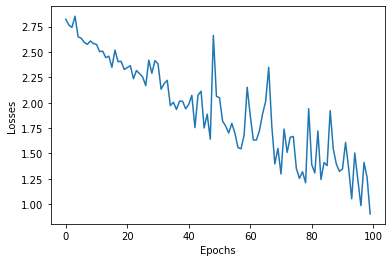

In [8]:
mnn = MultiLayerNN([input_amount, 2737, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 2048 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.743
Test Accuracy: 0.18054728146471266


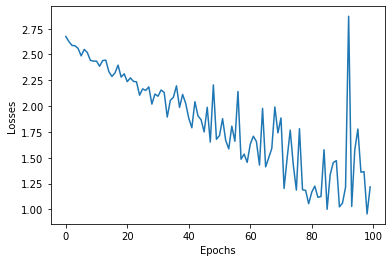

In [9]:
mnn = MultiLayerNN([input_amount, 2048, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 1024 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.805
Test Accuracy: 0.14238055522459192


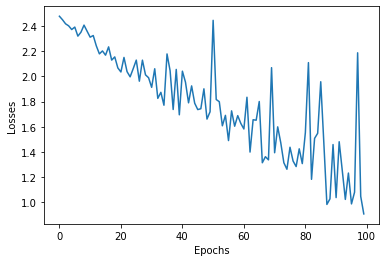

In [10]:
mnn = MultiLayerNN([input_amount, 1024, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 128 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.564
Test Accuracy: 0.16478017395448588


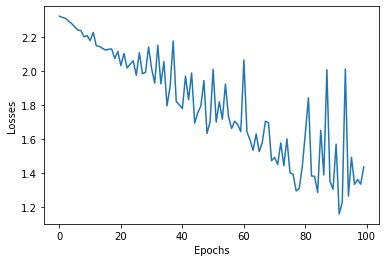

In [11]:
mnn = MultiLayerNN([input_amount, 128, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.482
Test Accuracy: 0.1944080384447357


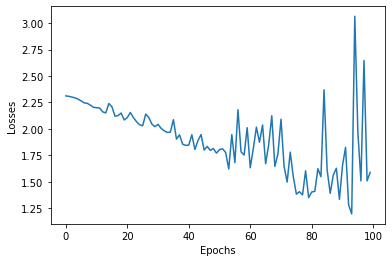

In [12]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

As we can clearly see from above test, the best result is taken from the hidden node amount that was suggested to us by the book that we have chosen as our source and the performance steadily dropped as we got further and further away from our suggestions. This may be caused by the inevitable overfitting issue that stems from less than ideal node amount that we picked in the other examples as the 

## Testing for batch size

Here we will test the size of batches that we may need when preparing our model.

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 128 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.367
Test Accuracy: 0.18293021962746733


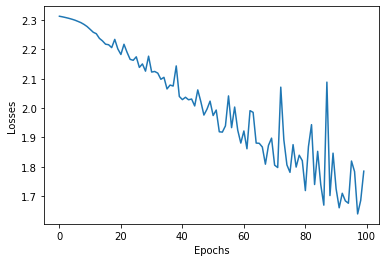

In [13]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=128, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.483
Test Accuracy: 0.1426585646769133


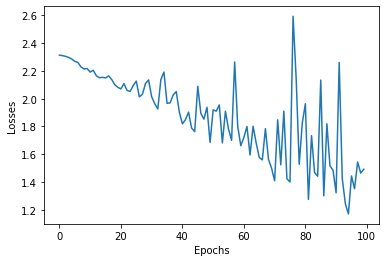

In [14]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 32 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.599
Test Accuracy: 0.22943722943722944


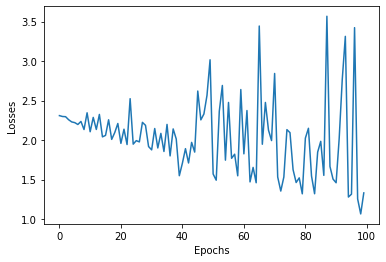

In [15]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=32, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 16 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.712
Test Accuracy: 0.15306406132094205


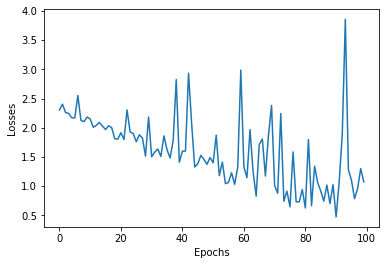

In [16]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=16, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

As we can see from above, there is a certain sweetspot of batch size where our model works the greates which is understandable since it is thought about as to vary how much our models work with different sizes of batches

## Testing for batch randomization

Here we test with four extremely simple Neural Networks to find out whether we should randomize every batch within our dataset for each epoch. The results of which may affect how our code performs both at the speed level and at the resulting accuracy level.

### No Hidden Layer
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.005 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.711
Test Accuracy: 0.130704158227094


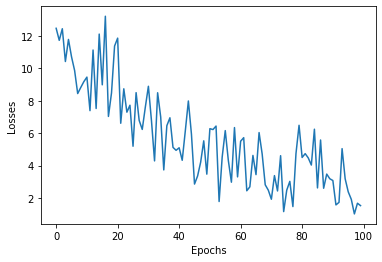

In [17]:
mnn = MultiLayerNN([input_amount, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### No Hidden Layer
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.005 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.69
Test Accuracy: 0.12065610230747846


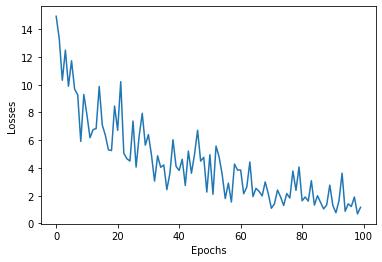

In [18]:
mnn = MultiLayerNN([input_amount, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.005 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.467
Test Accuracy: 0.1070733547797768


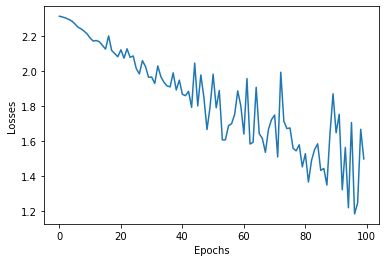

In [19]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.005 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.545
Test Accuracy: 0.17883950911473848


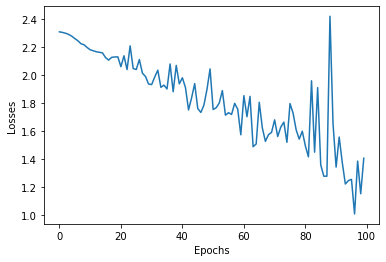

In [20]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=True, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

As we can see from above, the best result comes from a layered model with randomization which is normal as this randomization gives us the necessary normalization that we crave for a good model

## Changes in learning rate

Here we will test how the learning rate changes affect the results within our model's training and predictions

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Always Random
    - 100 Epoch Amount
    - 0.0005 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.108
Test Accuracy: 0.18789467413320624


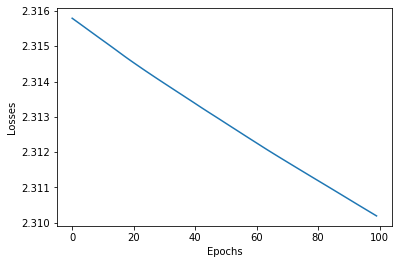

In [21]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-4, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.001 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.101
Test Accuracy: 0.1892052901227213


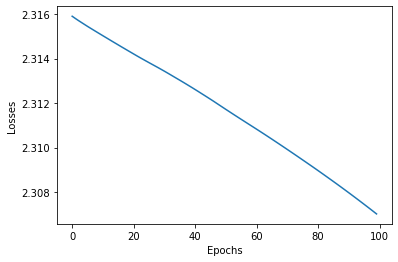

In [22]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=1e-3, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.01 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.317
Test Accuracy: 0.15842567218714007


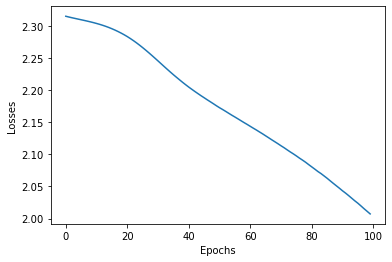

In [23]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=1e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.6
Test Accuracy: 0.15695619365344135


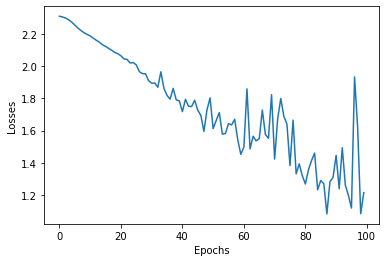

In [25]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.1 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.398
Test Accuracy: 0.17316017316017315


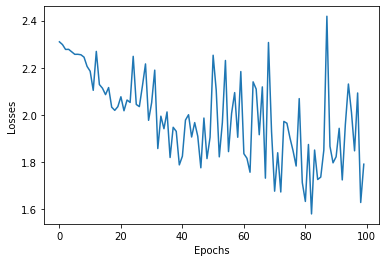

In [26]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=1e-1, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

As we can see from above, there is a certain sweetspot of learning rate where our model works best which completely logical as it is certain to vary how much our functions diverge and converge based upon the activation and objective functions we use.

## Changes in functions

Here we will test how the functions used affect the results within our model's training and predictions.

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.648
Test Accuracy: 0.1493705071686723


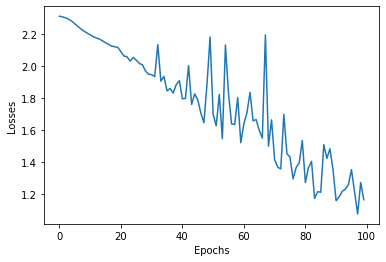

In [27]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - Sigmoid
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-5-8ecca1960c3d>:32: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-layer_input))


Training Accuracy: 0.1
Test Accuracy: 0.06227411731998888


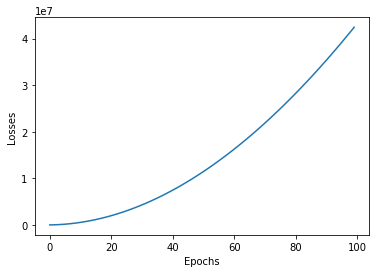

In [28]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="sigmoid")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - Tanh
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.814
Test Accuracy: 0.12319790301441677


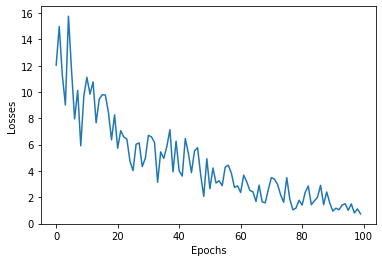

In [29]:
mnn = MultiLayerNN([input_amount, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="tanh")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

From above we can see that RELU works best when it comes to our own model which is understandable as RELU is usually seen as the best activation function. Next to RELU the accepted second best function tanh is giving good results too just behinf RELU but sigmoid seems to have diverged from our outputs which indicates its overall worseness.

## Changes in layer amount

Here we will test how the layer amount used affects the results within our model's training and predictions.

### One Hidden Layer
    - 64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.355
Test Accuracy: 0.14766273481869813


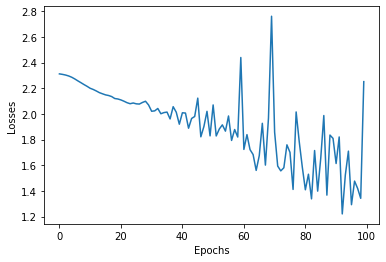

In [30]:
mnn = MultiLayerNN([input_amount, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### Two Hidden Layers
    - 64-64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy: 0.181
Test Accuracy: 0.1754239644147901


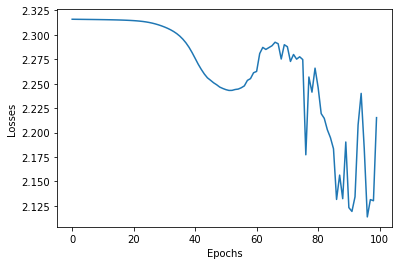

In [31]:
mnn = MultiLayerNN([input_amount, 64, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=100, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

### Three Hidden Layer
    - 64-64-64 Hidden Layer Nodes
    - RELU
    - 64 Batch Size - Not Always Random
    - 100 Epoch Amount
    - 0.05 Learning Rate

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Accuracy: 0.605
Test Accuracy: 0.14659041264545852


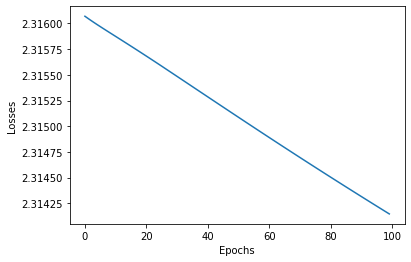

In [32]:
mnn = MultiLayerNN([input_amount, 64, 64, 64, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=1000, batch_size=64, batches_are_always_random=False, activation_func="relu")

accuracy = calculate_accuracy(image_array, train_df["class"].values.astype(int))
print("Training Accuracy:", accuracy)

accuracy = calculate_accuracy(test_image_array, test_df["class"].values.astype(int))
print("Test Accuracy:", accuracy)

mnn.plot_loss()

As we can see from our above tests, Layer amount highly affects the result we get from our predictions but not linearly as there seems to be a goldilocks zone where it is working best, which in our current example is 2.

## Visualization

In [33]:
mnn = MultiLayerNN([input_amount, output_amount], learning_rate=5e-2, regularization=1e-3)
mnn.fit(image_array, train_df["class"].values.astype(int), epoch_amount=1000, batch_size=64, batches_are_always_random=True, activation_func="relu")

  0%|          | 0/1000 [00:00<?, ?it/s]

### Dog Visualization

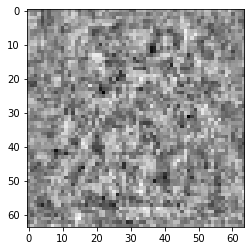

In [34]:
dog_array = mnn.linear_parameters["W1"][:, 0]
dog_array = np.reshape(dog_array, (64,64))

imgplot = plt.imshow(dog_array, cmap=plt.get_cmap("Greys"))

### Horse Visualization

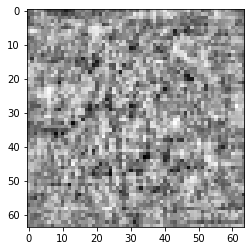

In [35]:
horse_array = mnn.linear_parameters["W1"][:, 1]
horse_array = np.reshape(horse_array, (64,64))

imgplot = plt.imshow(horse_array, cmap=plt.get_cmap("Greys"))

### Elephant Visualization

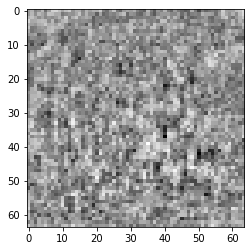

In [36]:
elephant_array = mnn.linear_parameters["W1"][:, 2]
elephant_array = np.reshape(elephant_array, (64,64))

imgplot = plt.imshow(elephant_array, cmap=plt.get_cmap("Greys"))

### Butterfly Visualization

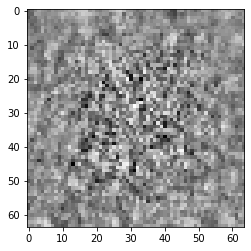

In [37]:
butterfly_array = mnn.linear_parameters["W1"][:, 3]
butterfly_array = np.reshape(butterfly_array, (64,64))

imgplot = plt.imshow(butterfly_array, cmap=plt.get_cmap("Greys"))

### Chicken Visualization

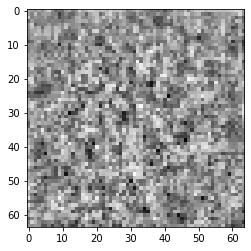

In [38]:
chicken_array = mnn.linear_parameters["W1"][:, 4]
chicken_array = np.reshape(chicken_array, (64,64))

imgplot = plt.imshow(chicken_array, cmap=plt.get_cmap("Greys"))

### Cat Visualization

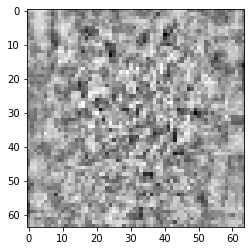

In [39]:
cat_array = mnn.linear_parameters["W1"][:, 5]
cat_array = np.reshape(cat_array, (64,64))

imgplot = plt.imshow(cat_array, cmap=plt.get_cmap("Greys"))

### Cow Visualization

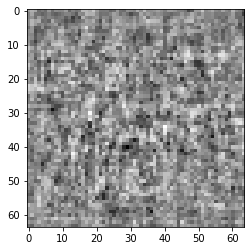

In [40]:
cow_array = mnn.linear_parameters["W1"][:, 6]
cow_array = np.reshape(cow_array, (64,64))

imgplot = plt.imshow(cow_array, cmap=plt.get_cmap("Greys"))

### Sheep Visualization

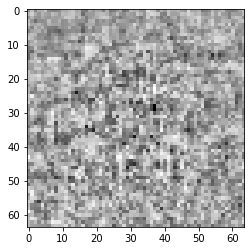

In [41]:
sheep_array = mnn.linear_parameters["W1"][:, 7]
sheep_array = np.reshape(sheep_array, (64,64))

imgplot = plt.imshow(sheep_array, cmap=plt.get_cmap("Greys"))

### Spider Visualization

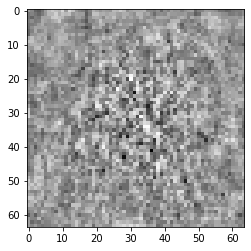

In [42]:
spider_array = mnn.linear_parameters["W1"][:, 8]
spider_array = np.reshape(spider_array, (64,64))

imgplot = plt.imshow(spider_array, cmap=plt.get_cmap("Greys"))

### Squirrel Visualization

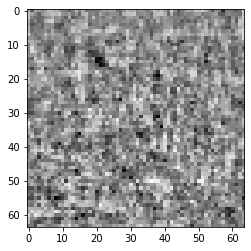

In [43]:
squirrel_array = mnn.linear_parameters["W1"][:, 9]
squirrel_array = np.reshape(squirrel_array, (64,64))

imgplot = plt.imshow(squirrel_array, cmap=plt.get_cmap("Greys"))

As we can see from above visual, some of them somewhat resemble their respective animals such as the dog and cat with their ears or butterfly with their wings which can be hardly seen when look upon their visualizations

# Part 2
## Convolutional Neural Network
In this part, we will use pretrained VGG-19 convolutional neural network and finetune this network to classify the sample images. We will finetune the weights of all layers in the VGG-19 network.


## Importing the necessary packages

In [ ]:
import numpy as np
from keras.optimizer_v1 import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg19
from keras.models import Sequential
from keras.layers import  Dense, Flatten, Activation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Define class names to use while plotting the confusion matrix later

In [ ]:
class_names = ["cane","cavallo","elefante","farfalla","gallina","gatto","mucca","pecora","ragno","scoiattolo"]

## Construct the base VGG19 model without including the top layer and input shapes given as default

In [ ]:
base_model = vgg19.VGG19( include_top=False,weights='imagenet',input_shape=(224,224,3))
base_model.summary()

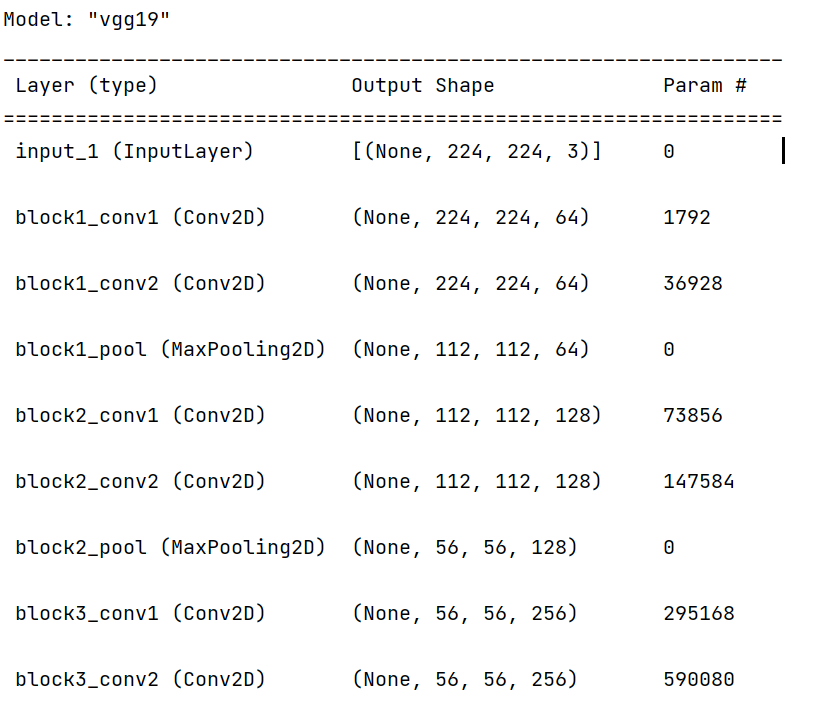

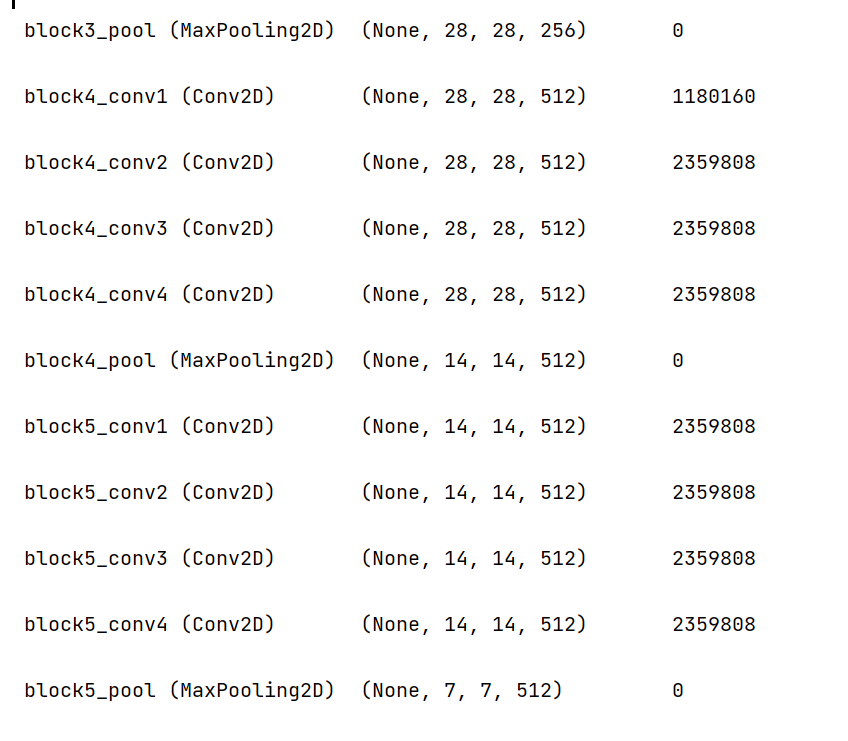

## Add all layers of VGG19 model which we defined as base model before to the model on which we will make predictions 

In [ ]:
model = Sequential()
for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

## Add the top layer of our model
Top layer is the output layer where the model makes prediction

In [ ]:
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1, activation='softmax'))

## Freezing vgg19 layers except last two fully connected layers
VGG19 saves its original weights except last two fully connected layers. It means that only last two layers will be updated by training

In [ ]:
layer_num = len(model.layers)
for layer in model.layers[:layer_num-3]:
    layer.trainable = False

for layer in model.layers[layer_num-3:]:
    layer.trainable = True

## Data Generator 
Data generator generates train, validation sets to fit our model later

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

## Generating Train, Test, Validation Sets

### Prepare Train Set
Prepares the train set for training the model

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_gen = datagen.flow_from_directory(
                                          directory=".//train_path//",
                                          target_size=(224, 224),
                                          color_mode="rgb",
                                          batch_size=32,
                                          class_mode="categorical",
                                          shuffle=True,
                                          seed=42)

### Prepare Validation Set
Prepares the validation set

In [ ]:
valid_gen = datagen.flow_from_directory(
                                          directory=".//valid_path//",
                                          target_size=(224, 224),
                                          color_mode="rgb",
                                          batch_size=32,
                                          class_mode="categorical",
                                          shuffle=True,
                                          seed=42
)

## Compile and fit model by using generated train and validation sets
Displays the accuracy and loss rates of each layers

In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'], loss='categorical_crossentropy')
model.fit(train_gen,epoch = 5,validation_data=valid_gen)

## Data Generator of Test Set
Data generator generates test set

In [ ]:
datagen_test = ImageDataGenerator(rescale = 1./255)

### Prepare Test Set
Prepares the test set for testing our model 

In [ ]:
test_gen = datagen.flow_from_directory(
                                                  directory=".//test_path//",
                                                  target_size=(224, 224),
                                                  color_mode="rgb",
                                                  batch_size=100,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42
)

## Test the model
Test the finetuned VGG19 model and store predicted classes.

In [ ]:
predictions = model.predict(test_gen)
print(predictions)

## Confusion Matrix

Define a confusion matrix function which shows the accuracy rate for each classes.

In [ ]:
def matrix(actual, predicted, classes, cmap=plt.cm.Blues):
    title = 'Confusion matrix of VGG19'

    # Computing confusion matrix
    comp = confusion_matrix(actual, predicted)
    comp = comp.astype('float') / comp.sum(axis=1)[:, np.newaxis]

    #Visualizing
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(comp, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(comp.shape[1]),
           yticks=np.arange(comp.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')
    # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = comp.max() / 2.
    for i in range(comp.shape[0]):
        for j in range(comp.shape[1]):
            ax.text(j, i, format(comp[i, j], fmt),
                    ha="center", va="center",
                    color="white" if comp[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Plotting the confusion matrix


In [ ]:
conf_matrix=confusion_matrix(test['category'],predictions)
matrix(test['category'], predictions, class_names)

# Multi Layer Neural Network vs Convolutional Neural Network
The disadvantage of Multi Layer Neural Network is that the total number of parameters can reach very high values. This is inefficient because there is redundancy in such high dimensions. Another disadvantage is that it does not take spatial information into account. It takes flattened vectors as input. Also it contains many parameters because it is fully connected. 

In Convolutional Neural Network, each filter wraps around the entire image to a specific size and pitch, allowing the filter to find and match patterns wherever the pattern is found in a given image. The weights are smaller, less wasteful, easier to train than the MLP. Even more effective. It can also go deeper. Layers are sparsely linked rather than fully connected. 

